# Multi head attention

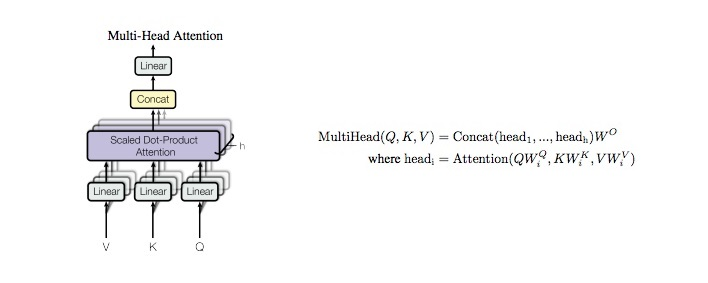

In [ ]:

from torch import nn

from models.layers.scale_dot_product_attention import ScaleDotProductAttention


class MultiHeadAttention(nn.Module):

    def __init__(self, d_model, n_head):
        super(MultiHeadAttention, self).__init__()
        self.n_head = n_head
        self.attention = ScaleDotProductAttention()
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.w_concat = nn.Linear(d_model, d_model)

    def forward(self, q, k, v, mask=None):
        # 1. dot product with weight matrices
        q, k, v = self.w_q(q), self.w_k(k), self.w_v(v)

        # 2. split tensor by number of heads
        q, k, v = self.split(q), self.split(k), self.split(v)

        # 3. do scale dot product to compute similarity
        out, attention = self.attention(q, k, v, mask=mask)

        # 4. concat and pass to linear layer
        out = self.concat(out)
        out = self.w_concat(out)

        # 5. visualize attention map
        # TODO : we should implement visualization

        return out

    def split(self, tensor):
        """
        split tensor by number of head

        :param tensor: [batch_size, length, d_model]
        :return: [batch_size, head, length, d_tensor]
        """
        batch_size, length, d_model = tensor.size()

        d_tensor = d_model // self.n_head
        tensor = tensor.view(batch_size, length, self.n_head, d_tensor).transpose(1, 2)
        # it is similar with group convolution (split by number of heads)

        return tensor

    def concat(self, tensor):
        """
        inverse function of self.split(tensor : torch.Tensor)

        :param tensor: [batch_size, head, length, d_tensor]
        :return: [batch_size, length, d_model]
        """
        batch_size, head, length, d_tensor = tensor.size()
        d_model = head * d_tensor

        tensor = tensor.transpose(1, 2).contiguous().view(batch_size, length, d_model)
        return tensor